In [1]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt


import ee
import geemap

import geopandas as gpd
import pprint 
import time as t

from osgeo import gdal
import pyproj


from rasterio.mask import mask
import shapely

import requests

import io
from io import BytesIO

from PIL import Image
!pwd

/Users/alexthomas/Desktop/EE_Fire/numpy


## GeoTIFFs and .shp file processing

In [4]:

root = "/Users/alexthomas/Desktop/EE_Fire/"
with rasterio.open('CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_day_of_burn_yearly_2016.tif') as src:
    print(type(src))
    raster_data = src.read(1) 
    print(type(raster_data))


RasterioIOError: CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_day_of_burn_yearly_2016.tif: No such file or directory

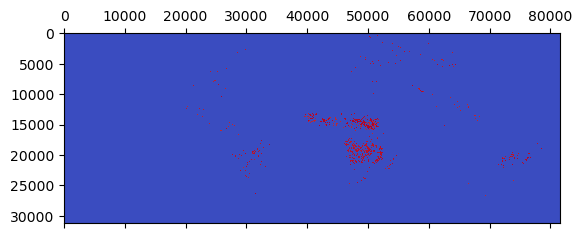

In [4]:
fig = plt.figure()
ax = fig.add_subplot()
ax.matshow(raster_data, cmap = 'coolwarm')

In [5]:
!pwd

source = root+"CMS_Global_Fire_Atlas_1642/data/"
file_name = "Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp"

print("starting:")
shape_file = gpd.read_file(source+file_name)
print("finished!")

/Users/alexthomas/Desktop/EE_Fire/numpy
starting:
finished!


In [6]:
filtered_data = shape_file[shape_file['size'] > 3]

In [7]:
sorted = filtered_data.sort_values(by='size', ascending=False)
#data = sorted.loc[1:3, ['fire_ID', 'size']]
#print(data)
data = sorted.iloc[0:5]
print(data.columns)

Index(['fire_ID', 'lat', 'lon', 'size', 'perimeter', 'start_date', 'start_DOY',
       'end_date', 'end_DOY', 'duration', 'expansion', 'fire_line', 'speed',
       'direction', 'direction_s', 'landcover', 'landcover_s', 'tile_ID',
       'geometry'],
      dtype='object')


In [7]:

print(data.crs)

EPSG:4326


In [8]:
#print(data.crs)
import rasterio.features



tiff_srs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"


# Create a CRS object using the proj4 string
tiff_crs = pyproj.CRS.from_proj4(tiff_srs)
gdf = data.to_crs(tiff_srs)
#print(gdf.crs)

geom = gdf.iloc[0].geometry
feature = rasterio.features.bounds(geom)

file_name = 'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_day_of_burn_yearly_2016.tif'

  
print(data.iloc[0].geometry.bounds)
print(gdf.iloc[0].geometry.bounds)

print(type(geom))
print(type(feature))
print(feature == geom.bounds)


##Out put should be:
#(125.61951148171264, -16.91666666519753, 127.28551214168341, -15.558333331985773)
#(13402246.951015044, -1881049.629108341, 13606104.546287326, -1730009.6835202402)
#<class 'shapely.geometry.multipolygon.MultiPolygon'>
#<class 'tuple'>
#True


(125.61951148171264, -16.91666666519753, 127.28551214168341, -15.558333331985773)
(13402246.951015044, -1881049.629108341, 13606104.546287326, -1730009.6835202402)
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'tuple'>
True


## Tests:

data crs: EPSG:4326
gdf crs: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs +type=crs
start date: 266
end date: 303
{'coordinates': (((13606104.546287326, -1881049.629108341),
                  (13606104.546287326, -1730009.6835202402),
                  (13402246.951015044, -1730009.6835202402),
                  (13402246.951015044, -1881049.629108341),
                  (13606104.546287326, -1881049.629108341)),),
 'type': 'Polygon'}
0
343
(328, 442)
| 463.31, 0.00, 13401783.64|
| 0.00,-463.31,-1729546.37|
| 0.00, 0.00, 1.00|


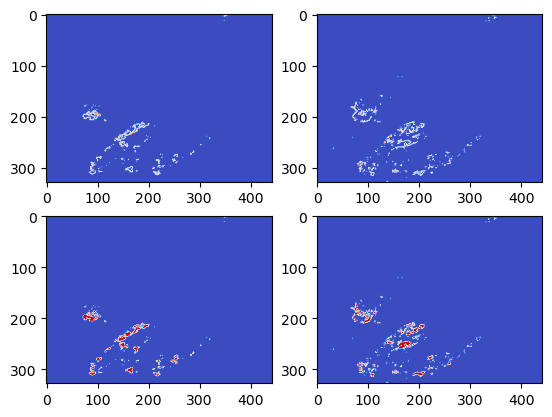

In [11]:

#See the switch in crs
print("data crs:", data.crs)
print("gdf crs:",gdf.crs)

# Load GeoTiff representing day-of-year of the burn
file_1 = 'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_fire_line_yearly_2016.tif'
file_2 = 'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_day_of_burn_yearly_2016.tif'

with rasterio.open(file_1) as src:
    with rasterio.open(file_2) as second:
        index = 0
        # Iterate over each forest fire
       # for idx, row in gdf.iterrows():  
        
        start_date = gdf.iloc[index]['start_DOY']
        end_date = gdf.iloc[index]['end_DOY']
        print(f"start date: {start_date}")
        print(f"end date: {end_date}")
        #Tuple of coords
        shape = gdf.iloc[index].geometry.bounds
        
        #Shapely polygon
        box = shapely.geometry.box(shape[0], shape[1], shape[2], shape[3]) 
        json = shapely.geometry.mapping(box)
        pprint.pprint(json)
        arr, out = rasterio.mask.mask(src, [json], crop = True, nodata = 0, pad = 1)
        arr2, out = rasterio.mask.mask(second, [json], crop = True, nodata = 0, pad = 1)
        print(np.min(arr))
        print(np.max(arr))
        
       # print(arr[0].shape)
      #  print(arr[0])
        fig = plt.figure()
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
        ax1.imshow((arr[0] == 290).astype(int), cmap = 'coolwarm')
        ax2.imshow((arr[0] == 291).astype(int), cmap = 'coolwarm')
        ax3.imshow((arr2[0] == 290).astype(int), cmap = 'coolwarm')
        ax4.imshow((arr2[0] == 291).astype(int), cmap = 'coolwarm')
        
        
        print(arr[0].shape)
        print(out)
    
    
        
    
        ## Google earth engine
    
    
    
    
    
    
            
            # Perform further processing or analysis with the extracted data

## Earth Engine

In [51]:
ee.Authenticate()


True

In [52]:
ee.Initialize()

In [20]:
print(data.iloc[0].geometry.bounds)

(125.61951148171264, -16.91666666519753, 127.28551214168341, -15.558333331985773)


In [36]:

roi = ee.Geometry.Rectangle(data.iloc[0].geometry.bounds)                                                    

era =ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterDate('2016-01-01','2016-01-02')

viz = {
'bands': ['v_component_of_wind_10m'],
    'max': 10.1,
    'min': -10.1,
    'palette':  ['#0000ff', '#00ffff', '#ffff00', '#ff0000']
}


list = era.toList(24)
ee.Image(list.get(12)).clip(roi)



img =  era.first().clip(roi)##This step could be changed to a reducer or to daily aggregate to become more accurate

print(ee.Image(img).get('hour').getInfo())

Map = geemap.Map()
Map.centerObject(roi)
Map.addLayer(img, viz, "image")

display(Map)

None


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [38]:

t1 = time.time()

url = img.getDownloadURL({
   
    'bands': ['v_component_of_wind_10m'],
    'region': roi,
    'format': "NPY",

    
  })


t2 = time.time()

print("download url:     ",    url)
print(f"\n{t2-t1}")


download url:      https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/6c4096444913ff5ea3a82e533fb7b215-fa4cb1bf9a03039697ae74884804c5ac:getPixels

1.838348150253296


In [39]:
print(url)
t3 = time.time()

r = requests.get(url, stream = True)

print(f"status code: {r.status_code} ")

if r.status_code != 200:
        r.raise_for_status()

array = np.array(np.load(BytesIO(r.content)).tolist())


t4 = time.time()

print('time:', t4-t3)

https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/6c4096444913ff5ea3a82e533fb7b215-fa4cb1bf9a03039697ae74884804c5ac:getPixels
status code: 200 
time: 2.082854986190796


(6, 8, 1)


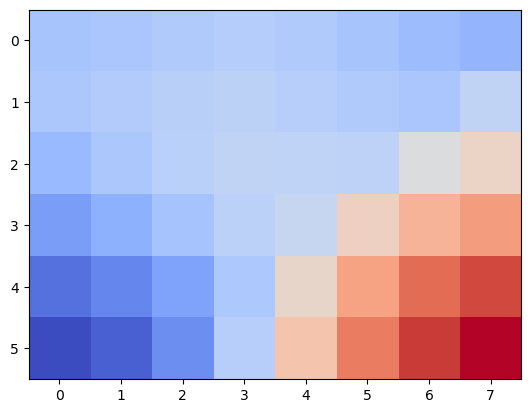

In [40]:
print(array.shape)

fig = plt.figure()
ax = fig.add_subplot()

ax.imshow(array, cmap = 'coolwarm')

In [238]:
data.iloc[0]

fire_ID                                                   869938
lat                                                     -15.7021
lon                                                     126.8622
size                                                     10124.0
perimeter                                                2145.54
start_date                                            2016-09-22
start_DOY                                                    266
end_date                                              2016-10-29
end_DOY                                                      303
duration                                                      38
expansion                                                 266.42
fire_line                                                 239.07
speed                                                       6.89
direction                                                      4
direction_s                                            southeast
landcover                

## Integration of both parts:

In [207]:
import time as t
arrays, s  = getArrays(250, "2016")


initializing data

Fetching urls:

Dowloading urls:
status code: 200 
status code: 200 
status code: 200 
status code: 200 


In [211]:
print(s)
print(arrays[3].shape)

15.372875928878784
(359, 182, 1)


In [214]:
collec = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").select('u_component_of_wind_10m')

img = collec.first()

print(img.projection().getInfo())
print(img.projection().crs().getInfo())
#convert = img.reproject(crs = ee.Projection('EPSG:4326'), crsTransform = img.projection().getInfo()['transform'])
#print(convert.projection().getInfo())

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.1, 0, -180.05, 0, -0.1, 90.05]}
EPSG:4326


In [165]:
collection  = ee.ImageCollection("ECMWF/ERA5/HOURLY")
img = collection.first()
print(img.projection().crs().getInfo())

EPSG:4326


In [247]:
for inx, row in data.iterrows():
    print(type(row))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>



import time as t
#i -- day of year as given by tiff
#year -- string of year
# data -- gdf with standard coords
# index -- fire index in geopandas data frame
def getArrays(i, year, data, index):
    
    num_retries = 3
    for l in range(0, num_retries):
        try: #use this to catch the dreaded RemoteDisconnect error
            display(f'\n{i}, initializing data')
            jan1 = ee.Date(year+'-01-01')
            
            t1 = t.time()
        
            roi = ee.Geometry.Rectangle(data.iloc[index].geometry.bounds)
        
            era_hourly = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") #use the hourly for better resolution
           
            era_daily = ee.ImageCollection("ECMWF/ERA5/DAILY") #use daily for aggregate values
           
            terra_vegetation =  ee.ImageCollection("MODIS/061/MOD13A1") # every 16 days resolution
             
             #ee.ImageCollection("MODIS/061/MOD13Q1")  # this is the 250 m resolution one
    
            #reprojected precip
            precipitation = era_daily.filterDate(jan1.advance(i-1,'day'), jan1.advance(i,'day'))\
                                .first()\
                             
            
            tree_cover = terra_vegetation.filterDate(jan1.advance(i-20,'day'), jan1.advance(i,'day'))\
                                                    .first()
            list = era_hourly.filterDate(jan1.advance(i-1, 'day'), jan1.advance(i,'day')).toList(24)
            tree_cover_reprojected = tree_cover.reproject(crs = ee.Projection('EPSG:4326'), scale = 500)#, #\crsTransform = tree_cover.projection().getInfo()['transform'])
        
            wind = ee.Image(list.get(12))#.clip(roi)#.reproject(crs = ee.Projection('EPSG:4326'))
                    
            
    
            ##get download URLS":
    
            display('\nFetching urls:')
            
            v_comp = wind.getDownloadURL({
           
                    'bands': ['v_component_of_wind_10m'],
                    'region': roi,
                    'format': "NPY",
                        
                    })
                                    
            u_comp = wind.getDownloadURL({
           
                    'bands': ['u_component_of_wind_10m'],
                    'region': roi,
                    'format': "NPY",
                        
                    })
        
            precip = precipitation.getDownloadURL({
                    
                    'bands': ['total_precipitation'],
                    'region': roi,
                    'format': "NPY",
           
                    })
        
            non_green_cover = tree_cover_reprojected.getDownloadURL({
        
                ##could use NDVI or EVI
                    'bands': ['NDVI'],
                    'region': roi,
                    'format': "NPY",
           
                    })
        
            display("\nDowloading urls:")
            url_list = [v_comp, u_comp, precip, non_green_cover]
        
            arrays = []
            #for redundancy use a try/ except block and then use if image_array is not None
            
            for url in url_list:
                for i in range(0, num_retries):
                    try:
                        r = requests.get(url, stream = True)
                                
                        display(f"status code: {r.status_code} ")
                                
                        if r.status_code != 200:
                            r.raise_for_status()
                                
                        arr = np.array(np.load(BytesIO(r.content)).tolist())
                        arrays.append(arr)
                        break
                         
                    except requests.exceptions.RequestException as e:
                        display(f"Error Downloading {url}:{e}")
                        display('\nretrying:')
                        time.sleep(5)
            
            t2 = t.time()
            return arrays, t2-t1
            break
        except Exception as e:
            error_type = type(e).__name__
            with open('errors.txt', 'w') as f:
                str = f"error at index : {index}, {error_type}"
                display(str)
                f.write(str)
                time.sleep(5)
                display('\nretrying')
        
        return (None, None)
    

In [8]:

import time as t
#i -- day of year as given by tiff
#year -- string of year
# data -- gdf with standard coords
# index -- fire index in geopandas data frame
def getArrays(i, year, data, index):
    
    num_retries = 3
    for l in range(0, num_retries):
        try: #use this to catch the dreaded RemoteDisconnect error
            display(f'\n{i}, initializing data')
            jan1 = ee.Date(year+'-01-01')
            
            t1 = t.time()
        
            roi = ee.Geometry.Rectangle(data.iloc[index].geometry.bounds)
        
            era_hourly = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") #use the hourly for better resolution
           
            era_daily = ee.ImageCollection("ECMWF/ERA5/DAILY") #use daily for aggregate values
           
            terra_vegetation =  ee.ImageCollection("MODIS/061/MOD13A1") # every 16 days resolution
             
             #ee.ImageCollection("MODIS/061/MOD13Q1")  # this is the 250 m resolution one
    
            #reprojected precip
            precipitation = era_daily.filterDate(jan1.advance(i-1,'day'), jan1.advance(i,'day'))\
                                .first()\
                             
            
            tree_cover = terra_vegetation.filterDate(jan1.advance(i-20,'day'), jan1.advance(i,'day'))\
                                                    .first()
            list = era_hourly.filterDate(jan1.advance(i-1, 'day'), jan1.advance(i,'day')).toList(24)
            tree_cover_reprojected = tree_cover.reproject(crs = ee.Projection('EPSG:4326'), scale = 500)#, #\crsTransform = tree_cover.projection().getInfo()['transform'])
        
            wind = ee.Image(list.get(12))#.clip(roi)#.reproject(crs = ee.Projection('EPSG:4326'))
                    
            
    
            ##get download URLS":
    
            display('\nFetching urls:')
            
            v_comp = wind.getDownloadURL({
           
                    'bands': ['v_component_of_wind_10m'],
                    'region': roi,
                    'format': "NPY",
                        
                    })
                                    
            u_comp = wind.getDownloadURL({
           
                    'bands': ['u_component_of_wind_10m'],
                    'region': roi,
                    'format': "NPY",
                        
                    })
        
            precip = precipitation.getDownloadURL({
                    
                    'bands': ['total_precipitation'],
                    'region': roi,
                    'format': "NPY",
           
                    })
        
            non_green_cover = tree_cover_reprojected.getDownloadURL({
        
                ##could use NDVI or EVI
                    'bands': ['NDVI'],
                    'region': roi,
                    'format': "NPY",
           
                    })
        
            display("\nDowloading urls:")
            url_list = [v_comp, u_comp, precip, non_green_cover]
        
            arrays = []
            #for redundancy use a try/ except block and then use if image_array is not None
            
            for url in url_list:
                for i in range(0, num_retries):
                    try:
                        r = requests.get(url, stream = True)
                                
                        display(f"status code: {r.status_code} ")
                                
                        if r.status_code != 200:
                            r.raise_for_status()
                                
                        arr = np.array(np.load(BytesIO(r.content)).tolist())
                        arrays.append(arr)
                        break
                         
                    except requests.exceptions.RequestException as e:
                        display(f"Error Downloading {url}:{e}")
                        display('\nretrying:')
                        t.sleep(5)
            
            t2 = t.time()
            display(t2-t1)
            return arrays
            break
        except Exception as e:
            error_type = type(e).__name__
            with open('errors.txt', 'w') as f:
                str = f"error at index : {index}, {error_type}"
                display(str)
                f.write(str)
                t.sleep(5)
                display('\nretrying')
        
        return None
    

#load geotiff
file_1 = 'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_fire_line_yearly_2016.tif'
file_2 = 'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_day_of_burn_yearly_2016.tif'

#files = [DOY , fire_line]

from IPython.display import clear_output, display

def getData(year, files, data, gdf):
    #gdf -- in geotiff coordinates
    #data  -- in standard coordinates
    

    dict = {}
    times = []
    with rasterio.open(files[0]) as dob: #day of burn
        with rasterio.open(files[1]) as fire_line: #fire line
          
            # Iterate over each forest fire
            count = 0

            for index, row in gdf.iterrows(): 
                
                display(f'\n\nindex: {index}')
                start_date = row['start_DOY']
                end_date = row['end_DOY']
        
                if(end_date < start_date):
                    end_date = 365
        
                
                display(f"\nstart date: {start_date}")
                display(f"end date: {end_date}\n")
        
        
                #Tuple of coords
                bounds = row.geometry.bounds
                
                #Shapely polygon
                box = shapely.geometry.box(bounds[0], bounds[1], bounds[2], bounds[3]) 
                json = shapely.geometry.mapping(box)
                
                dob_tiff, out = rasterio.mask.mask(dob, [json], crop = True, nodata = 0)
   
                fire_line_tiff, out2 = rasterio.mask.mask(fire_line, [json], crop = True, nodata = 0)

                temp = []
    
                #change this to for every date pair in the sequence

          
                for i in range(start_date, end_date-1):
                    clear_output()
                    arrays, seconds = getArrays(i, year, data, count)
    
                    if(arrays!=None):
                        arrays.insert(0, (dob_tiff[0] == i).astype(int))
                        arrays.insert(1, (fire_line_tiff[0]== i).astype(int))
                        #this makes it 0 indexed not indexed from the DOB like 266
                        temp.append(arrays)
                        display(f't-values : {seconds}')
                        times.append(seconds)
                    else: ##this is the error handling for the extended try / except block in getArrays().;jyuiop
                        pass
                 
                dict[index] = temp
                count+=1

 
    return dict, times
                ## Google earth engine
            
    
    



        
        # Perform further processing or analysis with the extracted data

In [9]:
ee.Authenticate()
ee.Initialize()



In [10]:
#load geotiff
file_1 = 'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_fire_line_yearly_2016.tif'
file_2 = 'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_day_of_burn_yearly_2016.tif'

#files = [DOY , fire_line]

from IPython.display import clear_output, display

def getData(year, files, data, gdf):
    #gdf -- in geotiff coordinates
    #data  -- in standard coordinates
    

    dict = {}
    times = []
    with rasterio.open(files[0]) as dob: #day of burn
        with rasterio.open(files[1]) as fire_line: #fire line
          
            # Iterate over each forest fire
            count = 0
            
            for index, row in gdf.iterrows(): 
                
                display(f'\n\nindex: {index}')
                start_date = row['start_DOY']
                end_date = row['end_DOY']
        
                if(end_date < start_date):
                    end_date = 365
        
                
                display(f"\nstart date: {start_date}")
                display(f"end date: {end_date}\n")
        
        
                #Tuple of coords
                bounds = row.geometry.bounds
                
                #Shapely polygon
                box = shapely.geometry.box(bounds[0], bounds[1], bounds[2], bounds[3]) 
                json = shapely.geometry.mapping(box)
                
                dob_tiff, out = rasterio.mask.mask(dob, [json], crop = True, nodata = 0, pad = 1 )
   
                fire_line_tiff, out2 = rasterio.mask.mask(fire_line, [json], crop = True, nodata = 0, pad = 1)

                temp = getArrays(start_date, year, data, count)
                temp.insert(0, (dob_tiff[0] == start_date).astype(int))
                temp.insert(1, (fire_line_tiff[0]== start_date).astype(int))
                    
    
                #change this to for every date pair in the sequence

          
                for i in range(start_date, end_date-1):
                    clear_output()
                        
                        ## pre is the same as arr[i-1]
                    pre = temp
                        #temp is same as arr[i]
                    temp = getArrays(i, year, data, count)


                    if(temp!=None):
                        try:
                            temp.insert(0, (dob_tiff[0] == i).astype(int))
                            temp.insert(1, (fire_line_tiff[0]== i).astype(int))
                                #this makes it 0 indexed not indexed from the DOB like 266
                        
                                
                                
                                        
                            arr0, arr1, arr2, arr3, arr4, arr5 = pre[0], pre[1], pre[2], pre[3], pre[4], pre[5]
                            dob, fire_line= temp[0], temp[1]
                                
                            np.savez_compressed(f'compressed_{index}_{i}.npz', array1=arr0, array2=arr1, array3 = arr2, array4 = arr3, 
                                        array5 = arr4, array6 = arr5, array7 = dob, array8 = fire_line)
                            display(f'saved at {index}, {i}')
                                
                           
                        except Exception as e:
                                print(f'exception at {i}: {e}')
                    else: ##this is the error handling for the extended try / except block in getArrays().;jyuiop
                        pass
                    
                    
                count+=1

 
    return dict, times
                ## Google earth engine
            

In [17]:
import time
file_1 = root+'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_fire_line_yearly_2016.tif'
file_2 = root+'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_day_of_burn_yearly_2016.tif'

#files need to be in this format
#files = [DOY, fire_line]

files = [file_1, file_2]


#initialize crs conversion
tiff_srs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
tiff_crs = pyproj.CRS.from_proj4(tiff_srs)

#define data (recall sorted definition from earlier)
data = sorted.iloc[0:50] 

tiff_data = data.to_crs(tiff_srs)


year = '2016'


#output format should be like this
#dict = { 'fire id (8172640): list}
#list = [DOB, fire_line, u_comp_wind, v_comp_wind, precipitation, forest cover]

dict = getData(year, files, data, tiff_data)




'\n301, initializing data'

'\nFetching urls:'

'\nDowloading urls:'

'status code: 200 '

'status code: 200 '

'status code: 200 '

'status code: 200 '

13.005328893661499

'saved at 874883, 301'

'\n\nindex: 431188'

'\nstart date: 325'

'end date: 365\n'

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [19]:
!pwd

/Users/alexthomas/Desktop/EE_Fire


dict_keys([123099])
<class 'list'>
4


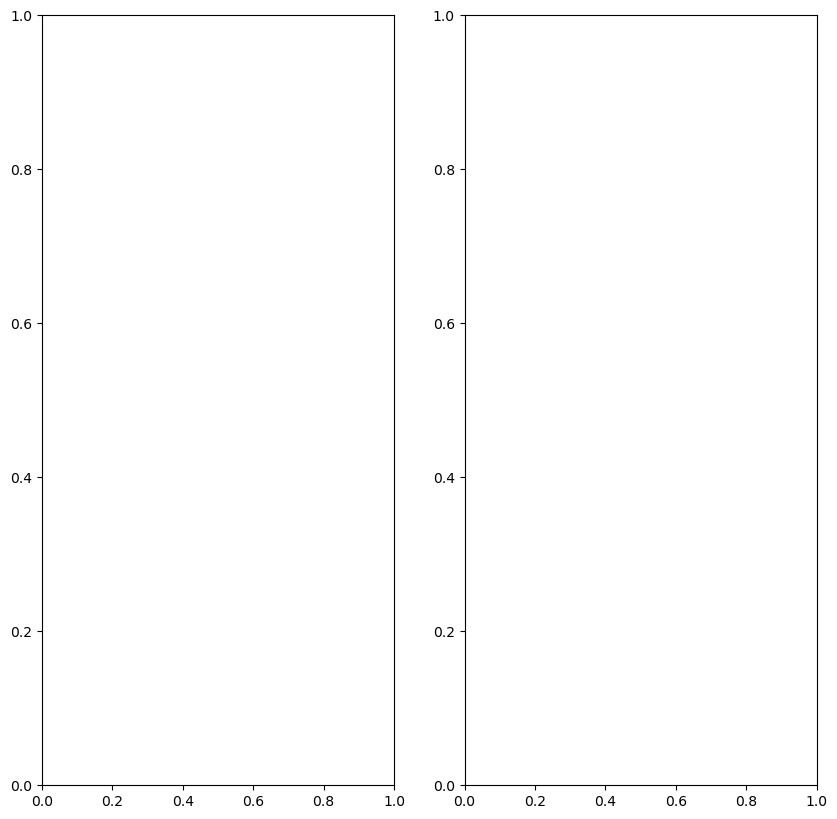

In [48]:


%matplotlib inline





#print(dict[874883][0][0].shape)

keys = dict.keys()
print(keys)



for key in keys:
    
    lst = dict[key]
    print(type(lst))
    temp = lst[0]
    print(len(lst))
    for i in range(0, len(lst)-1):
        
        try:
           
            arr1 = temp
                
            temp = lst[i+1]

            
                
        
            
        
            arr0, arr1, arr2, arr3, arr4, arr5 = arr1[0], arr1[1], arr1[2], arr1[3], arr1[4], arr1[5]
            dob, fire_line= temp[0], temp[1]
            
            np.savez_compressed(f'compressed_{key}_{i}.npz', array1=arr0, array2=arr1, array3 = arr2, array4 = arr3, 
                                array5 = arr4, array6 = arr5, array7 = dob, array8 = fire_line)

        
        except Exception as e:
            print(f'exception at {i}: {e}')

          #  print(temp)
            print(type(temp))



fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(121)
#ax.imshow(dict[874883][0][0] , cmap = 'Reds')

ax1 = fig.add_subplot(122)
#ax1.imshow(dict[874883][0][1] , cmap = 'Reds')

#ax3 = fig.add_subplot(163)
#ax3.imshow(dict[874883][0][2], cmap = 'coolwarm')


#ax4 = fig.add_subplot(164)
#ax4.imshow(dict[874883][0][3], cmap = 'coolwarm')

#ax5 = fig.add_subplot(165)
#ax5.imshow(dict[874883][0][4], cmap = 'coolwarm')

#ax6 = fig.add_subplot(166)
#ax6.imshow(dict[874883][0][5], cmap = 'Greens')




In [396]:
!pwd

/Users/alexthomas/Desktop/EE_Fire


<class 'numpy.lib.npyio.NpzFile'>


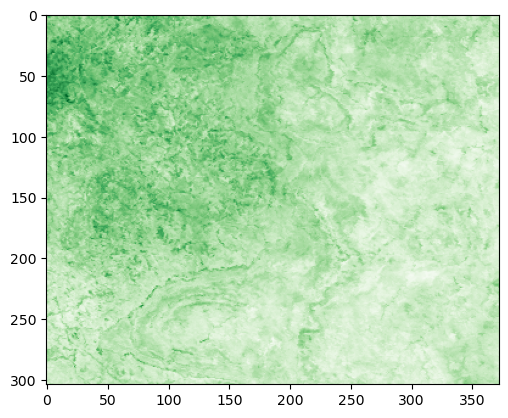

In [414]:
key = 874883
i = 0

str = f'compressed_{key}_{i}.npz'
collection = np.load(str)
print(type(collection))
f = collection['array6']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow((f), cmap = 'Greens')
